# Implementing CNN

In [1]:
import numpy as np
from activations import ReLU,Sigmoid,Tanh,Softmax
from layers import Linear,Conv2d,Flatten
from loss import CEloss
from utils import load_dataset,plot_confusion_matrix,plot_history,plot_predictions,compute_accuracy

In [2]:
class Model():
    def __init__(self, lr):
        self.Conv_layer = Conv2d(1,3,5,1,0,lr)
        self.relu = ReLU()
        self.flatten = Flatten()
        self.linear = Linear(48,10,lr)
        self.softmax = Softmax()
        self.Loss = CEloss()
    
    def forward(self,input):
        x = self.Conv_layer.forward(input)
        x = self.relu.forward(x)
        x = self.flatten.forward(x)
        x = self.linear.forward(x)
        probs = self.softmax.forward(x)
        return probs
    
    def cal_loss(self,y_true,y_pred):
        loss = self.Loss.CalLoss(y_true,y_pred)
        return loss
    
    def backward(self):
        error_signal = self.Loss.backward()
        error_signal = error_signal[:,np.newaxis,:]
        jacobian = self.softmax.backward()
        error_signal = error_signal@jacobian
        error_signal = np.squeeze(error_signal,axis=1)
        linear_back = self.linear.backward(error_signal)
        flatten_back = self.flatten.backwards(linear_back)
        relu_back = self.relu.backward()
        error_signal = flatten_back*relu_back
        error_back = self.Conv_layer.backward(error_signal)
    
    def predict(self,input):
        probs = self.forward(input)
        y_hat = np.argmax(probs,axis=1,keepdims=True)
        return y_hat



In [3]:
x_train, x_test, y_train, y_test = load_dataset()
print(x_train.shape)
print(y_train.shape)

(1437, 1, 8, 8)
(1437, 10)


## Training

In [4]:
history = []
accuracy_history = []
model = Model(lr=0.001)
def Train(model,x_train,y_train,epochs):
    for epoch in range(epochs):
        probs = model.forward(x_train)
        loss = model.cal_loss(y_train,probs)
        print(f'epoch{epoch} loss = {loss}')
        predictions = model.predict(x_train)
        accuracy = compute_accuracy(predictions,y_train)
        accuracy_history.append(accuracy)
        print(f'epoch{epoch} acc = {accuracy}')
        history.append(loss)
        model.backward()

Train(model,x_train,y_train,5)
plot_history(history)

epoch0 loss = 6.298786087899934
epoch0 acc = 0.10090466249130133
epoch1 loss = 6.216890045983862
epoch1 acc = 0.1009022411474458
epoch2 loss = 6.137455065045159
epoch2 acc = 0.1009022411474458
epoch3 loss = 6.060528632653248
epoch3 acc = 0.1009022411474458
epoch4 loss = 5.9861540364859565
epoch4 acc = 0.1009022411474458
Traning loss plot saved at /Users/hassan/repos/CNN_numpy/figures/training_loss.png


Prediction plot saved at /Users/hassan/repos/CNN_numpy/figures/predictions.png
Confusion Matrix plot saved at /Users/hassan/repos/CNN_numpy/figures/confusion_matrix.png


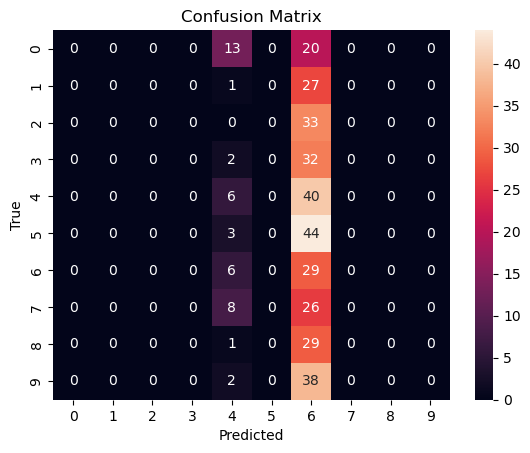

In [28]:
predictions = model.predict(x_test)
acc = compute_accuracy(predictions,y_test)
plot_predictions(x_test,predictions,acc)
plot_confusion_matrix(y_test,predictions)